# IMD3004 - Aprendizado Profundo

### Professor: Dr. Silvan Ferreira da Silva Junior

### Aluno: João Antonio Costa Paiva Chagas

## Importações

In [11]:
import torch
import torchvision
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Configurações

In [12]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Modelo e funções auxiliares

In [13]:
class SimpleNet(nn.Module):
    def __init__(self, init_type="he", dropout=0.0):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(784, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=dropout),

            nn.Linear(64, 10)
        )
        self._initialize_weights(init_type)

    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

    def _initialize_weights(self, init_type):
        for m in self.layers:
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, nonlinearity="relu")
                init.zeros_(m.bias)

In [14]:
def train_model(model, train_loader, val_loader, optimizer, scheduler=None, epochs=10):
    criterion = nn.CrossEntropyLoss()
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "lr": []}

    model = model.to(device)

    for epoch in range(epochs):
        # Treino
        model.train()
        total_loss, correct, total = 0, 0, 0
        for data, target in tqdm(train_loader, desc=f"Época {epoch+1}/{epochs} - Treino"):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        history["train_loss"].append(total_loss / len(train_loader))
        history["train_acc"].append(100 * correct / total)

        # Validação
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        history["val_loss"].append(epoch_val_loss)
        history["val_acc"].append(100 * correct / total)
        history["lr"].append(optimizer.param_groups[0]['lr'])

        # Scheduler
        if scheduler:
            # ReduceLROnPlateau
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)
            else:
                scheduler.step()

        print(f"Época {epoch+1}/{epochs} | "
              f"Loss Treino: {history['train_loss'][-1]:.4f}, "
              f"Acc Treino: {history['train_acc'][-1]:.2f}% | "
              f"Loss Val: {history['val_loss'][-1]:.4f}, "
              f"Acc Val: {history['val_acc'][-1]:.2f}% | "
              f"LR: {history['lr'][-1]:.6f}")
    return history

In [15]:
def plot_loss_and_lr(history, title="Evolução da Loss e da Taxa de Aprendizado"):
    """
    Plota a evolução da loss de treino/validação em um eixo Y
    e a taxa de aprendizado (LR) em um segundo eixo Y.
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(history['train_loss'], 'b--', label='Loss de Treino')
    ax1.plot(history['val_loss'], 'b-', label='Loss de Validação')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Cross-Entropy Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc='upper left')
    ax1.set_title(title)
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(history['lr'], 'r.-', label='Taxa de Aprendizado (LR)')
    ax2.set_ylabel('Taxa de Aprendizado', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_yscale('log')
    ax2.legend(loc='upper right')

    plt.show()

## Exercício

Neste exercício, você deve aplicar os conceitos vistos em aula:

### 1. Carregue o dataset **Fashion-MNIST** de `torchvision.datasets.FashionMNIST` e aplique **normalização** com `transforms.Normalize`, calculando previamente a média e o desvio padrão.  

In [16]:
# Carregando Fashion-MNIST
temp_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True
)
loader = DataLoader(temp_dataset, batch_size=len(temp_dataset), shuffle=False)
data = next(iter(loader))[0]
mean, std = data.mean(), data.std()
print(f"Média calculada: {mean:.4f}")
print(f"Desvio padrão calculado: {std:.4f}\n")

# Cálculo da Normalização
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# Datasets
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=transform_norm, download=True
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, transform=transform_norm, download=True
)

# DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

Média calculada: 0.2860
Desvio padrão calculado: 0.3530



### 2. Construa um modelo de rede neural utilizando:  
   - **Camadas lineares** intercaladas com **Batch Normalization** e **ReLU**
   - **Inicialização He** para os pesos

In [17]:
model = SimpleNet(init_type="he")
model.to(device)

SimpleNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.0, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

### 3. Treine o modelo usando o **otimizador Adam**.  

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

### 4. Utilize o scheduler **ReduceLROnPlateau**, monitorando a loss de validação, para ajustar dinamicamente a taxa de aprendizado.

In [20]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

### 5. Registre e plote a evolução da loss de treino e validação ao longo das épocas, além da curva da taxa de aprendizado.

Iniciando treinamento...


Época 1/20 - Treino: 100%|██████████| 235/235 [00:16<00:00, 14.02it/s]


Época 1/20 | Loss Treino: 0.4558, Acc Treino: 83.44% | Loss Val: 0.4192, Acc Val: 85.09% | LR: 0.010000


Época 2/20 - Treino: 100%|██████████| 235/235 [00:17<00:00, 13.48it/s]


Época 2/20 | Loss Treino: 0.3407, Acc Treino: 87.46% | Loss Val: 0.3606, Acc Val: 86.72% | LR: 0.010000


Época 3/20 - Treino: 100%|██████████| 235/235 [00:16<00:00, 14.32it/s]


Época 3/20 | Loss Treino: 0.3047, Acc Treino: 88.77% | Loss Val: 0.3445, Acc Val: 87.43% | LR: 0.010000


Época 4/20 - Treino: 100%|██████████| 235/235 [00:17<00:00, 13.33it/s]


Época 4/20 | Loss Treino: 0.2816, Acc Treino: 89.45% | Loss Val: 0.3493, Acc Val: 86.95% | LR: 0.010000


Época 5/20 - Treino: 100%|██████████| 235/235 [00:17<00:00, 13.26it/s]


Época 5/20 | Loss Treino: 0.2647, Acc Treino: 89.98% | Loss Val: 0.3219, Acc Val: 88.18% | LR: 0.010000


Época 6/20 - Treino: 100%|██████████| 235/235 [00:18<00:00, 12.74it/s]


Época 6/20 | Loss Treino: 0.2446, Acc Treino: 90.86% | Loss Val: 0.3225, Acc Val: 88.16% | LR: 0.010000


Época 7/20 - Treino: 100%|██████████| 235/235 [00:16<00:00, 13.87it/s]


Época 7/20 | Loss Treino: 0.2343, Acc Treino: 91.15% | Loss Val: 0.3261, Acc Val: 88.53% | LR: 0.010000


Época 8/20 - Treino: 100%|██████████| 235/235 [00:21<00:00, 10.96it/s]


Época 8/20 | Loss Treino: 0.2236, Acc Treino: 91.57% | Loss Val: 0.3436, Acc Val: 87.94% | LR: 0.010000


Época 9/20 - Treino: 100%|██████████| 235/235 [00:17<00:00, 13.23it/s]


Época 9/20 | Loss Treino: 0.2077, Acc Treino: 92.13% | Loss Val: 0.3351, Acc Val: 88.64% | LR: 0.010000


Época 10/20 - Treino: 100%|██████████| 235/235 [00:17<00:00, 13.82it/s]


Época 10/20 | Loss Treino: 0.1584, Acc Treino: 94.14% | Loss Val: 0.3120, Acc Val: 89.54% | LR: 0.001000


Época 11/20 - Treino: 100%|██████████| 235/235 [00:18<00:00, 12.99it/s]


Época 11/20 | Loss Treino: 0.1434, Acc Treino: 94.78% | Loss Val: 0.3116, Acc Val: 89.56% | LR: 0.001000


Época 12/20 - Treino: 100%|██████████| 235/235 [00:16<00:00, 14.23it/s]


Época 12/20 | Loss Treino: 0.1370, Acc Treino: 95.00% | Loss Val: 0.3165, Acc Val: 89.57% | LR: 0.001000


Época 13/20 - Treino: 100%|██████████| 235/235 [00:17<00:00, 13.71it/s]


Época 13/20 | Loss Treino: 0.1319, Acc Treino: 95.17% | Loss Val: 0.3242, Acc Val: 89.47% | LR: 0.001000


Época 14/20 - Treino: 100%|██████████| 235/235 [00:17<00:00, 13.74it/s]


Época 14/20 | Loss Treino: 0.1276, Acc Treino: 95.39% | Loss Val: 0.3302, Acc Val: 89.43% | LR: 0.001000


Época 15/20 - Treino: 100%|██████████| 235/235 [00:16<00:00, 14.31it/s]


Época 15/20 | Loss Treino: 0.1226, Acc Treino: 95.56% | Loss Val: 0.3309, Acc Val: 89.44% | LR: 0.001000


Época 16/20 - Treino: 100%|██████████| 235/235 [00:16<00:00, 14.22it/s]


Época 16/20 | Loss Treino: 0.1132, Acc Treino: 95.98% | Loss Val: 0.3322, Acc Val: 89.54% | LR: 0.000100


Época 17/20 - Treino: 100%|██████████| 235/235 [00:16<00:00, 14.36it/s]


Época 17/20 | Loss Treino: 0.1113, Acc Treino: 95.97% | Loss Val: 0.3338, Acc Val: 89.48% | LR: 0.000100


Época 18/20 - Treino: 100%|██████████| 235/235 [00:16<00:00, 14.20it/s]


Época 18/20 | Loss Treino: 0.1103, Acc Treino: 96.08% | Loss Val: 0.3342, Acc Val: 89.56% | LR: 0.000100


Época 19/20 - Treino: 100%|██████████| 235/235 [00:16<00:00, 14.35it/s]


Época 19/20 | Loss Treino: 0.1099, Acc Treino: 96.04% | Loss Val: 0.3352, Acc Val: 89.53% | LR: 0.000100


Época 20/20 - Treino: 100%|██████████| 235/235 [00:16<00:00, 14.13it/s]


Época 20/20 | Loss Treino: 0.1079, Acc Treino: 96.18% | Loss Val: 0.3360, Acc Val: 89.45% | LR: 0.000010
Treinamento finalizado!


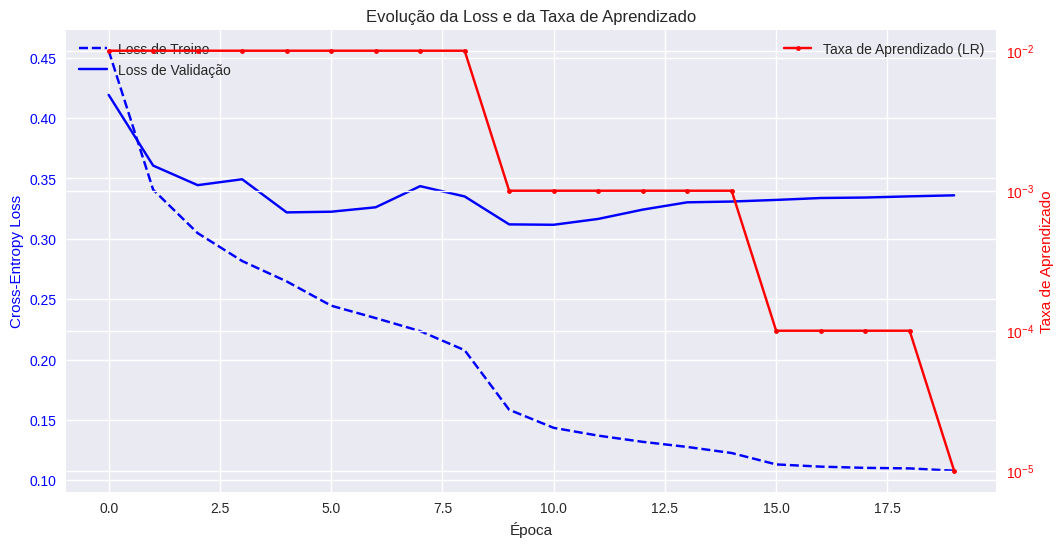

In [21]:
print("Iniciando treinamento...")
history = train_model(model, train_loader, val_loader, optimizer, scheduler, epochs=20)
print("Treinamento finalizado!")
plot_loss_and_lr(history)

### Observações

* O treinamento começa com um `LR` alto (0.01). Isso permite que o modelo aprenda rápido, como visto na queda da *loss* de validação nas primeiras épocas.
* Por volta da época 4, a *loss* de validação para de cair e começa a flutuar num platô. O modelo não consegue mais melhorar. Isso acontece porque o *LR* é tão alto que o otimizador pula de um lado para o outro do ponto mínimo da função de custo, sem conseguir assentar. O *scheduler* percebe isso e após 3 épocas sem uma nova melhora na *loss* de validação (paciência esgotada), ele reduz a taxa de aprendizado (de 0.01 para 0.001)  na época 8.
* Após a redução do `LR`, a `loss` de validação volta a cair. Com "passos" menores, o otimizador consegue encontrar um caminho para um mínimo melhor.
* O modelo continua aprendendo até que, por volta da época 11, atinge um novo platô. A história se repete: após 3 épocas sem melhora, o *scheduler* age novamente na época 14, reduzindo o `LR` para 0.0001.